<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse-2d/blob/master/src/notebook/format_binaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VNET pour la reconstruction de la densité d'un domaine

L'objectif de ce notebook est de **reconstruire la dénsité d'un domaine** à l'aide des signaux récupérés sur ses quatres bords. Il s'agit d'un problème inverse qu'on va résoudre à l'aide d'un Vnet. Ce travail fait suite à un stage durant lequel la résolution du problème direct (par un schéma de volume finis en deux temps) associé à été détaillée. Durant ledit stage, un problème inverse similaire au présent problème a été résolu par un réseau de neurone convolutif [👉 Rapport de stage.](https://github.com/desmond-rn/projet-inverse-2d/blob/master/doc/fr/rapport.pdf)

Ce notebook fait suite à une brève présentation des enjeux et du problème direct associé (voir `Slides.pdf`).  

In [ ]:
%reset -f

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import sklearn
from sklearn import metrics
import struct
from keras import backend as K


import gc
from IPython.display import Image
from ast import literal_eval as l_eval

In [ ]:
np.set_printoptions(precision = 3)

## Les données

In [ ]:
""" DEPUIS GOOGLE DRIVE """
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/Problème\ Inverse/2D\ VNet
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/Problème Inverse/2D VNet

Apprentissage.ipynb       img/                      test/      VNET07.h5
ApprentissageVnet1.ipynb  InterpolationUnet2.ipynb  train/     VNET08.h5
ApprentissageVnet2.ipynb  legacy/                   val/
ApprentissageVnet4.ipynb  LossMetrics/              VNET05.h5
ApprentissageVnet.ipynb   Slides.pdf                VNET06.h5


### Desciption des données

Tout d'abord, une brève desciption du transfer radiatif s'impose. On considère un rayonnement transporté par des particules de masse nulle appelés **photons**.
Lorsqu’ils se trouvent en présence de la matière, les photons interagissent avec les atomes. Trois phénomènes sont prépondérants:
- l'émission
- l'absorption
- la dispersion

[👉 Cliquez ce lien pour plus de détails.](https://github.com/desmond-rn/projet-inverse-2d/blob/master/doc/fr/rapport.pdf)

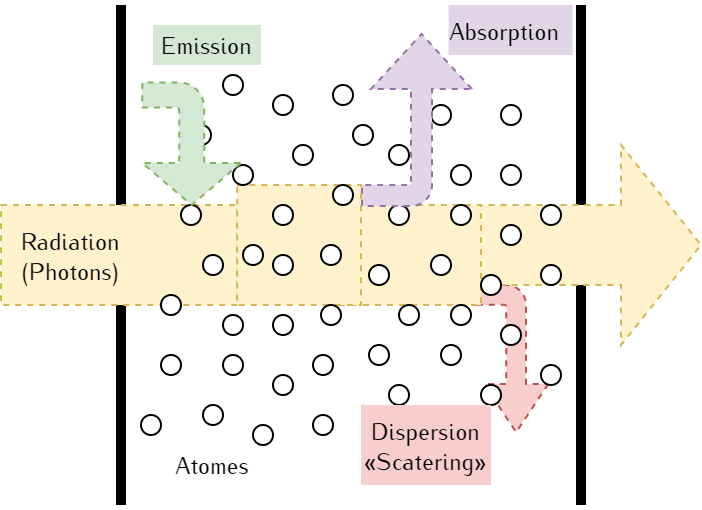

In [7]:
Image("img/TransferRadiatif.png",width="500")

Au niveau mésoscopique, trois quantités nous intéressent: 
- l'énergie des photons, 
- l'intensité de leur flux
- la température du milieu  

Le domaine étudié est carré. On fixe la source sur un bord différent à chaque nouvelle simulation. On récupère l'énergie des photons, l'intensité du flux de photons, et la température du milieu sur chacun des bords du domaine. Un sample pour le réseau de neurone sera constitué de ces 4 simulations. Ceci justifie les $4\times4\times3=48$ cannaux qu'on retouvera tout au long de cet apprentissage.

Considérons par exemple la densité ci-bas. On observe clairement deux zone de forte densités dans ce domaine. Ces zones seront asimilées à des obstacles, ou des tumeurs.

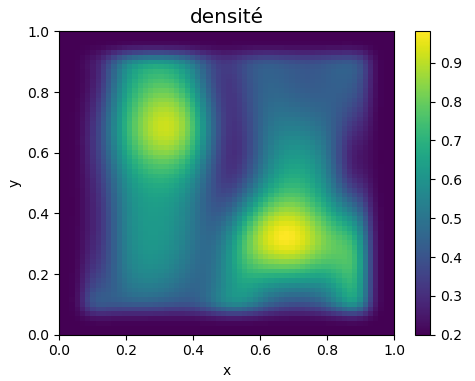

In [ ]:
## DensitTest
Image("img/DensiteTest.png",width="500")

On fixe le signal infrarouge sur la gauche du domaine, et on applique des conditions de Neumann aux autres bords. 

In [5]:
### Video test correspondant a la densité test
from IPython.display import HTML
from base64 import b64encode
mp4 = open("img/VideoTest.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

On change le bord sur lequel se trouve la source et on relance des simulations. Le signal récupéré sur les quatres bords du domaine en vue de l'entrainement du réseau de neurones est le suivant (une échelle de couleurs différentes pour chacunes des 4 figures autour d'une densité).

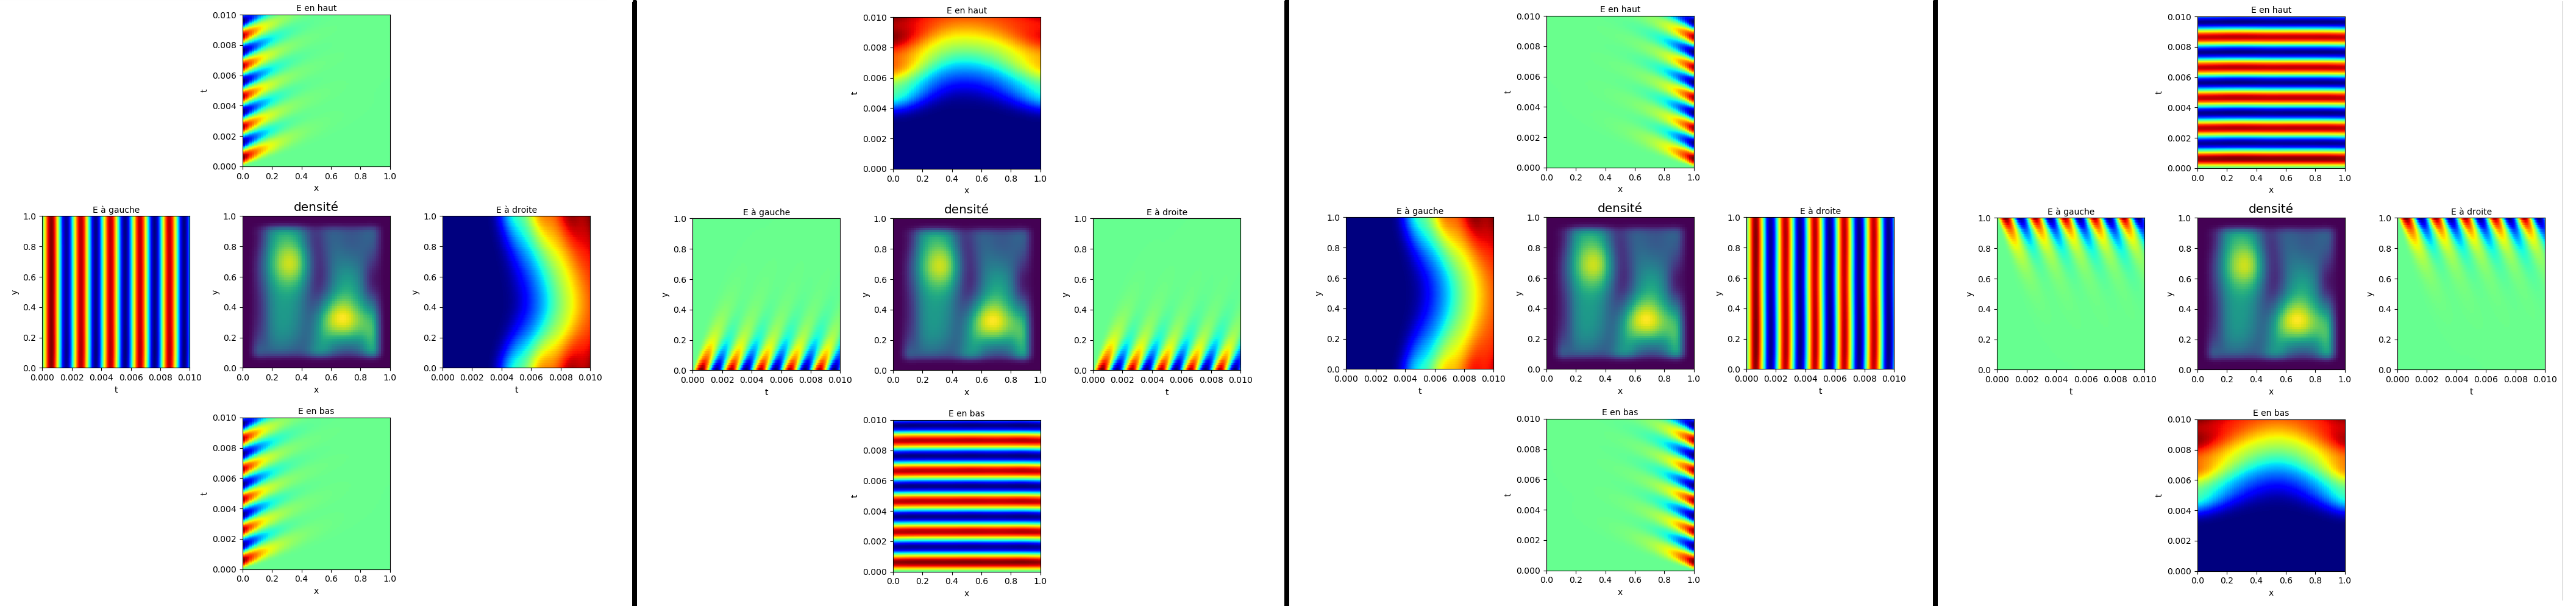

In [6]:
Image("img/SimuCirculaires.png",width="1600")

De plusieurs manières, ceci ressemble à un CT scan où on fait touner la source de rayon-X autour du patient; et on assemble les sections récupérées pour en fomer une image 3D.

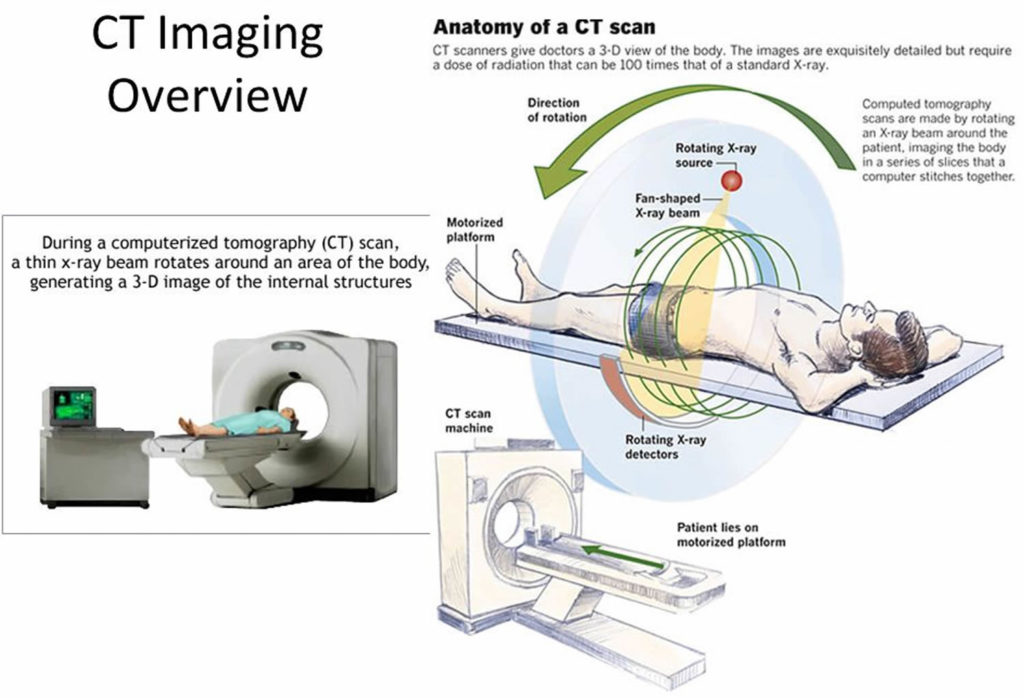

In [ ]:
## Image issue de [Poona Hospital Compound](https://www.omegapds.com/what-are-ct-scans-and-how-do-they-work/) 
Image("img/CTScan.jpg",width="600")

### Recupération des données

Comme on pourra le constater ci-bas, les données ont été prétraitées (reéchantillonées, normalisées, shufflelisées, etc.) dans un notebook précédent.

In [ ]:
############################################################# EN LOCAL
# X_train = np.load("../data/inversePB/train/X.npy")
# Y_train = np.load("../data/inversePB/train/Y.npy")
#############################################################

X_train = np.load("train/X.npy")
Y_train = np.load("train/Y.npy")
print("Train shapes", X_train.shape, Y_train.shape)
print()
print("X Max and Min: ", X_train.max(), X_train.min())
print("Y Max and Min: ", Y_train.max(), Y_train.min())

Train shapes (1950, 64, 64, 48) (1950, 64, 64, 1)

X Max and Min:  1.0 0.0
Y Max and Min:  1.0 0.10091702238501658


In [ ]:
############################################################# EN LOCAL
# X_val = np.load("../data/inversePB/val/X.npy")
# Y_val = np.load("../data/inversePB/val/Y.npy")
#############################################################

X_val = np.load("val/X.npy")
Y_val = np.load("val/Y.npy")
print("Validation shapes", X_val.shape, Y_val.shape)

Validation shapes (750, 64, 64, 48) (750, 64, 64, 1)


In [ ]:
############################################################# EN LOCAL
# X_test = np.load("../data/inversePB/test/X.npy")
# Y_test = np.load("../data/inversePB/test/Y.npy")
#############################################################

X_test = np.load("test/X.npy")
Y_test = np.load("test/Y.npy")[:,:,:,0]   ## derniere dimension inutile pour les plots
print("Test shapes", X_test.shape, Y_test.shape)

Test shapes (183, 64, 64, 48) (183, 64, 64)


## Description du Unet et du Vnet

Le **U-Net** fut crée par Olaf Ronneberger, Philipp Fischer, Thomas Brox en 2015 dans la publication intitulée “***U-Net: Convolutional Networks for Biomedical Image Segmentation***”. D'apres les auteurs de la publication, l'architecture est constituée d'une partie **contractante** (descendante) pour capturer les information interessantes, et d'une partie symétrique **expansive** (ascendante) pour une localisation précise des informations [👉 Lien pour l'aricle original](https://arxiv.org/pdf/1505.04597.pdf).

Comme on l'a vu en cours, le Vnet c'est le "petit-frere" du Unet. Ils font tous les deux partie d'une famille de réseaux appelés **fully convolutional networks**.


In [ ]:
# Image("img/uNet_origin.png",width="800")

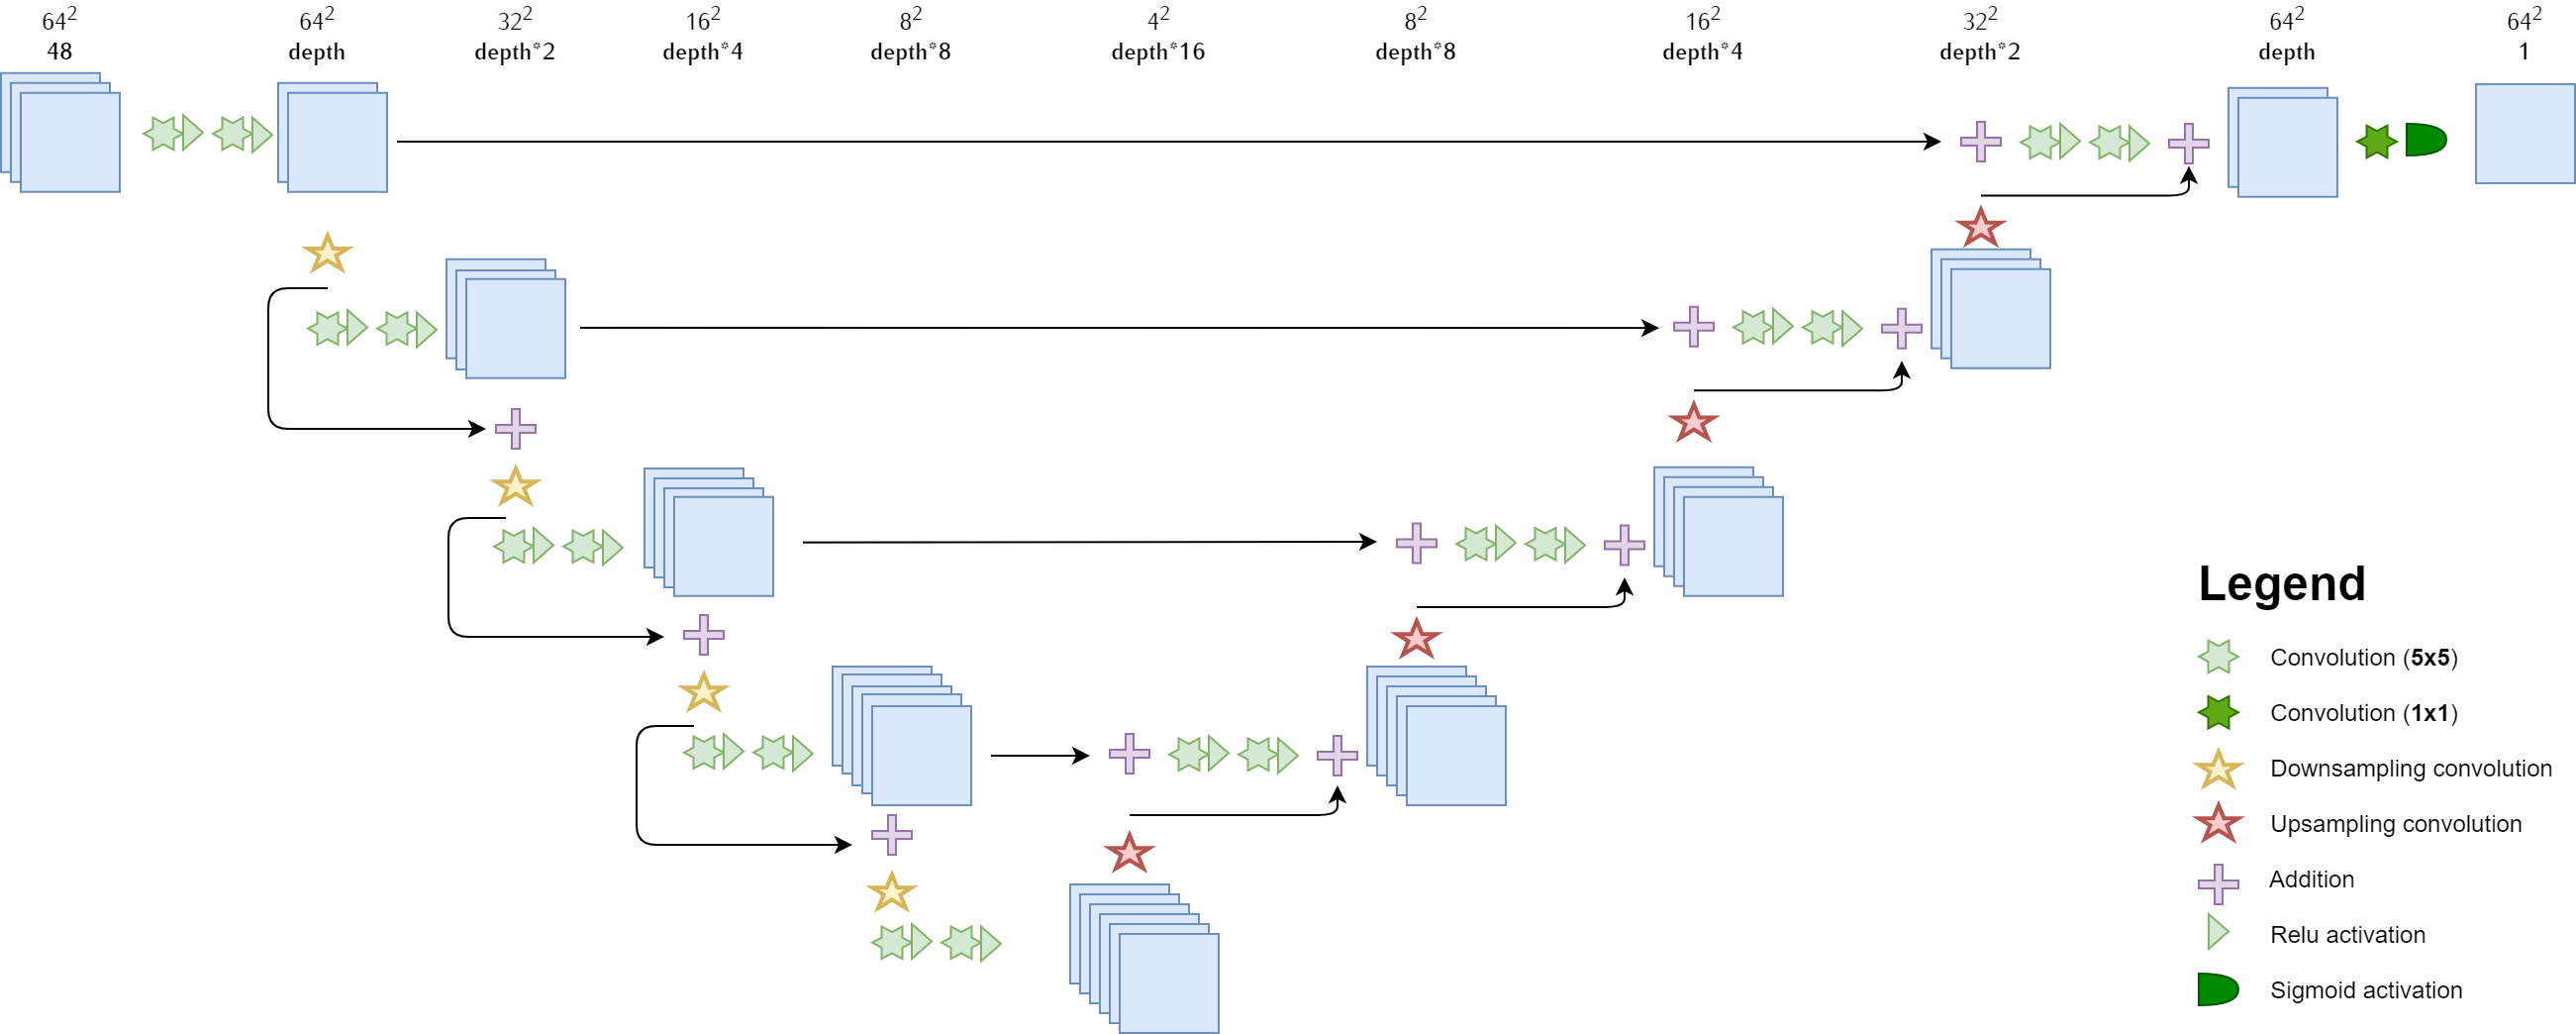

In [ ]:
Image("img/Vnet.png",width="1200")

Cette section est directement inspirées du cours qu'on a vu en UE de _Traitement de Signal 2_ avec M. Vigon. 

Coupons  le dessin en deux verticalement (en enlevant pour l'instant les grands traits horizontaux). 

* ***La partie gauche = l' analyse.*** C'est exactement un CNN sans la partie fully-connected (Dense).  Chaque layer diminue la taille des images d'un facteur 2 à l'aide d'un max pooling, et on multiplie la `depth` par 2. A la fin  (=tout en bas) on obtient `depth`*16 images de taille 4**4. Ce sont des **feature-maps** (=motifs) qui synthétisent les informations importantes de l'image.


* ***La partie droite = la synthèse.*** C'est  un miroir de la partie gauche. Elle sert à combiner les feature-maps pour reconstituer l'output (= la densité). La résolution des images est doublée à chaque layer, et simultanément, on diminue la profondeur. Pour dilater les images, on utilise  des `up-sampling`. 


* ***Les grand racoursis:*** Ce sont les longues flèches horizontales. Elles rajoutent des détails immédiatement issus de la partie gauche. En particulier les information de ***localisation des feature-maps*** qui ont été perdue durant la contraction (diminution de résolution).   

* ***La toute fin:*** On termine par une sigmoïde (ou une softmax), ce qui n'indique pas forcément que le réseau va effectuer une __`classification`__, c'est juste que les données `x_true, y_true` ont été normalisée, et sont comprises entre 0 et 1. On peut voire ca comme un **indice** pour le réseau de neuronne (apprentissage supervisé).

Comparé au Unet orignal proposé par Ronneberger, Fischer, et Brox, voici quelques différences:

* Les max-polling sont remplacés par des convolution avec `stride=2`, ce qui produit une compression plus douce. 

* Les up-sampling sont remplacés par des **deconvolution** (convolution transposée) avec `stride=2`. Tout comme avec la convolution, son kernel (de taille `5x5`) fera partie partie des paramètres entrainables par le réseau de neurones.

* On utilise des racoursis verticaux à la "resNet". Les information résiduelle sont apprises.

* On a ajouté une batch normalisation et un spacial-droptout (qui ne sont pas noté dans le dessin). 

* Les concaténations ont été remplacées par des sommations, ce qui diminue le nombre de paramètres. 


## Construction du Vnet

In [ ]:
Conv = tf.keras.layers.Conv2D                           ## Convolution
DeConv = tf.keras.layers.Conv2DTranspose                ## Deconvolution
SpatialDropout = tf.keras.layers.SpatialDropout2D       ## Dropout

class VNet:
    
    def __init__(self,
                 input_shape,
                 output_shape,                  
                 levels=5,                      ## Le nombre de niveaux 
                 depth=32,                       ## Le nombre de channel au niveau 1
                 kernel_size=5, 
                 activation="relu",
                 batch_norm=True,
                 dropout_rate=0, 
                 ): 

        self.input_shape=input_shape
        self.output_shape=output_shape
        self.levels = levels
        self.depth = depth
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm=batch_norm
        self.dropout_rate = dropout_rate

        assert len(input_shape)==3
        assert len(output_shape)==3
        assert (input_shape[0], input_shape[1]) == (output_shape[0], output_shape[1]), "Input and output dimensions should be alike in a VNET"

        ##---------- Le model, ses inputs et des outputs -----------##
        inputs= tf.keras.Input(shape=input_shape)
        logits= self.body(inputs)

        if self.output_shape[2]==1:    ## Output number of channels equals 1
            outputs = Conv(1,1, activation='sigmoid')(logits)                         ## On utilise une sigmoid parceque les donnees ont éte normalisées
        else:   
            outputs = Conv(self.input_shape[2],1, activation='softmax')(logits)       ## Le softmax peut servir a avoir une image RGB par exemple, c'est pas specifiquement lié à la classification

        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        ##----------------------------------------------------------##
        
    def doubleConv(self, Y, depth):
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)    ## On pourra essayer avec valid comme dans le papier!
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)
        if self.batch_norm:
            Y = tf.keras.layers.BatchNormalization()(Y)
        if self.dropout_rate>0:                             ## S'il n'ya pas de dropout, on ne fait rien !
            Y = SpatialDropout(self.dropout_rate)(Y)        ## Dans le SpatialDropout, si on cache une portion de l'image, on la cahe totalement. Pas la peine de chacher seulement certains neurones! 
        return Y

    def makeDown(self, Y, depth):       ## Une simple descente d'un level au suivant
        down = Conv(depth, 2, strides=2, padding="same")(Y)
        return down

    def makeUp(self, Y, depth):         ## une simple remontée 
        up = DeConv(depth, 2, strides=2, padding="same")(Y)
        return up

    def body(self,inputs):
        left = {}     ## On sauvegarde la partie gauche à additionner avec la partie droite
        left[0] = self.doubleConv(inputs,self.depth)
        print("left[0].shape =",left[0].shape)
        for i in range(1, self.levels):                           ## Une boucle pour la descente
            down = self.makeDown(left[i-1], self.depth*2**i)
            conv = self.doubleConv(down, self.depth*2**i)
            left[i] = tf.keras.layers.Add()([down, conv])         ## L'addition c'est comme des racourcis à la resnet ## essayons des multiplications
            if i<self.levels-1:
                print(f"left[{i}].shape=",left[i].shape)

        central = left[self.levels-1]
        print(f"central.shape=",central.shape)

        right=central
        for i in range(self.levels-2, -1,-1):                     ## une boucle pour la remontée
            up = self.makeUp(right, self.depth*2**i)
            add = tf.keras.layers.Add()([left[i], up])
            conv = self.doubleConv(add, self.depth*2**i)
            right = tf.keras.layers.Add()([up, conv])
            print(f"right[{i}].shape =",right.shape)

        return right

    @tf.function                                              ## Pour accelerer le code lors des prédictions
    def __call__(self,inputs):
        return self.model(inputs)

In [ ]:
modelParams= {'input_shape':(64,64,48),
              'output_shape':(64,64,1),
              'levels':5,
              'depth':32,
              'kernel_size':5,
              'activation':'relu',
              'batch_norm': True,
              'dropout_rate': 0.0}

tf.config.run_functions_eagerly(False)   ## True pour une desactivation de tf.function

## Petit résumé du modèle
myVnet = VNet(**modelParams)

left[0].shape = (None, 64, 64, 32)
left[1].shape= (None, 32, 32, 64)
left[2].shape= (None, 16, 16, 128)
left[3].shape= (None, 8, 8, 256)
central.shape= (None, 4, 4, 512)
right[3].shape = (None, 8, 8, 256)
right[2].shape = (None, 16, 16, 128)
right[1].shape = (None, 32, 32, 64)
right[0].shape = (None, 64, 64, 32)


In [ ]:
## Gros résumé du modèle
# myVnet.model.summary()

## Les fonctions pour l'entraînement 

### La DICE multi-D

Il s'agit de la dice classique (2D), sauf qu'on effectue une sommation suivant tous ses axes. Nous ne l'utiliserons pas, vu qu'une simple MSE est bien plus efficace.

In [ ]:
""" Pour calculer la DICE multi-D """
def dice_coef_multiD(y_true, y_pred,smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred,axis=None)      ## Ne faut-il pas rajouter des axes?
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true,axis=None) + tf.reduce_sum(y_pred,axis=None) + smooth)
    "on somme la dice_1D sur les cannaux en fait"
    return tf.reduce_mean(dice)

def dice_loss_multi_D(y_true, y_pred):
    smooth=1e-5
    return 1-dice_coef_multiD(y_true, y_pred,smooth)

### Le score $R^2$


In [ ]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=None) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=None)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

On peut à présent compiler le modèle qu'on a créé. L'expérience sur ce poblème nous a montré qu'il faut un taux d'apprentissage très bas pour que le modèle converge (en supposant que le problème direct sous-jacent fût bien posé). On choisira l'optimiseur Adam avec `lr=1e-5` pour le moment. Dans la suite, on vera que qu'il faudra encore baisser cette valeur pour affiner les résultats. On fait ceci malgrès qu'il y a [des sources](https://www.jeremyjordan.me/nn-learning-rate/#:~:text=3e%2D4%20is%20the%20best,rate%20for%20Adam%2C%20hands%20down.) qui conseillent `3e-4`, et [d'autres](https://keras.io/api/optimizers/adam/#:~:text=keras.-,optimizers.,Defaults%20to%200.001.) `1e-3` ou encore `1e-4` comme valeur "optimale" pour Adam (vu qu'il s'agit d'un algorithme adaptatif). Il faut aussi noter qu'Adam n'est pas parfait, il existe des algorithmes de descente qui tentent de corriger Adam (ND-Adam, etc.). Bref, ***chaque problème est particulier, il ne faut pas limiter son exploration d'hyperparamètres à cause des "avis des experts"***.

In [ ]:
# model.model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss=dice_loss_multi_D, metrics=[r2_score])
# myVnet.model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss="MSE", metrics=[r2_score])

Cependant, vu que l'apprentissage ***sera très long***, on peut aussi charger les poids d'un modèle précédement entrainé, et continuer le traivail à partir de là.

In [ ]:
myVnet.model = keras.models.load_model("VNET08.h5", custom_objects={"r2_score": r2_score}, compile=False)
myVnet.model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="MSE", metrics=[r2_score])

### Les fonctions de Callback

Le scheduleur permettra de baisser (ou d'augmenter) le taux d'ppentissage (=le lerning rate) une fois que le modèle aura "suffisament" convergé. 

**Attention, tout se fait manuellement!!**

In [ ]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
    return 1e-7

lr_decrease = keras.callbacks.LearningRateScheduler(scheduler)

L'early stopping permet d'éviter le surapprentissage. Tout comme le scheduleur pour le taux d'apprentissage, on ne rajoutera ce callback que si l'on juge que le modèle est suffisament bon pour mériter de se faire enregistrer.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50, monitor="r2_score", mode="max", restore_best_weights=True)

## La génération des données pour l'entrainement

Un probleme se pose pour l'entrainemnent: nos données sont trop volumineuses pour fonctionner correctentment sous les restrictions mémoires de Google Colab (**12.72** Gigaoctet). On a deux stratégies pour palier ce problème:
- On peut utiliser des générateurs de données (**DataGenerators**): mais ils sont trops lents (temps d'acces au HDD environ 200 fois plus lent qu'avec une DRAM, en plus de la virtualisation qui se passe sur Colab), et comme on le vera, il faudra effectuer des miliers d'epoques d'entrainement pour aboutir à un resultat satisfaisant.

- On décide tout de même de charger les données en mémoire, et n'effectuer qu'une seule epoque à la fois. Nos données, de taille environ **3** Go (après réechantillonement) peuvent bien rentrer en memoire. Il faudra quand même s'assurer qu'on recupère bien l'espace memoire non utilisé par le systeme après chaque époques en se servant du **garbage collector**.



Ci-dessous on a une implémentation des DataGenerator sous Keras.

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, listIDs, batchSize=32, dimX=(64,64,48), dimY=(64,64,1), shuffle=True):
        'Initialization'
        self.dimX = dimX
        self.dimY = dimY
        self.batchSize = batchSize
        self.listIDs = listIDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.listIDs) // self.batchSize

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batchSize:(index+1)*self.batchSize]

        # Find list of IDs
        listIDstemp = [self.listIDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(listIDstemp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.listIDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, listIDstemp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batchSize, *self.dimX))
        Y = np.empty((self.batchSize, *self.dimY))

        # Generate data
        for i, ID in enumerate(listIDstemp):
            # Store sample
            X[i] = np.load('inputs/' + str(ID) + '.npy')

            # Store output
            Y[i] = np.load('outputs/' + str(ID) + '.npy')

        return X, Y

In [ ]:
# Parameters for datagenerators
dataGenparams = {'dimX': (64,64,48), 
                'dimY': (64,64,1),
                'batchSize': 50,
                'shuffle': True}

# Datasets
partitions = {'train':np.arange(0,1000), 'val':np.arange(1000,1350), 'test':np.arange(1350,1446)}

# Generators
trainingGenerator = DataGenerator(partitions['train'], **dataGenparams)
validationGenerator = DataGenerator(partitions['val'], **dataGenparams)

## L'entraînement proprement dit 

On définit des variables à visualiser.

In [ ]:
loss = []
val_loss = []

r2_score = []
val_r2_score = []

In [ ]:
nb_epochs=0     ## Ne pas reinitialiser cette variables. Elle indique le nombre total d'époques effectuées.

In [ ]:
## Relancer cette cellule autant de fois

for i in range(500):   ## Nonbre d'époques à efectuer, l'une après l'autre 

    print("epoch nb:", nb_epochs)    ## Le nombre d'époques effectuées jusqu'a présent

    #####--------------- Utilisation des générateurs de données ------------######
    # history = myVnet.model.fit(trainingGenerator,
    #                           validation_data = validationGenerator,
    #                           # use_multiprocessing = True,
    #                           initial_epoch=nb_epochs,
    #                           epochs=nb_epochs+1,
    #                           workers=6)
    #####-------------------------------------------------------------------######

    #####--------------- Chargement directe des données en mémoire ---------######
    history = myVnet.model.fit(
              x=X_train,
              y=Y_train,
              batch_size=100,
              initial_epoch=nb_epochs,            ## Tant que la variable nb_epochs n'est pas reinitialisée, on continue l'entrainement
              epochs=nb_epochs+1,                 ## On effectue une époque à la fois 
              validation_data=(X_val,Y_val),
              callbacks=[lr_decrease, early_stopping],
              verbose=2
              )
    #####-------------------------------------------------------------------######

    loss.append(history.history["loss"][0])
    val_loss.append(history.history["val_loss"][0])
    r2_score.append(history.history["r2_score"][0])
    val_r2_score.append(history.history["val_r2_score"][0])

    nb_epochs += 1

    gc.collect()    ## Collect all unused memory for another group of epochs

epoch nb: 1000
Epoch 1001/1001
20/20 - 6s - loss: 0.0019 - r2_score: 0.9378 - val_loss: 0.0035 - val_r2_score: 0.8757
epoch nb: 1001
Epoch 1002/1002
20/20 - 6s - loss: 0.0018 - r2_score: 0.9388 - val_loss: 0.0028 - val_r2_score: 0.9013
epoch nb: 1002
Epoch 1003/1003
20/20 - 6s - loss: 0.0018 - r2_score: 0.9415 - val_loss: 0.0028 - val_r2_score: 0.9004
epoch nb: 1003
Epoch 1004/1004
20/20 - 6s - loss: 0.0018 - r2_score: 0.9420 - val_loss: 0.0029 - val_r2_score: 0.8958
epoch nb: 1004
Epoch 1005/1005
20/20 - 6s - loss: 0.0018 - r2_score: 0.9372 - val_loss: 0.0029 - val_r2_score: 0.8979
epoch nb: 1005
Epoch 1006/1006
20/20 - 6s - loss: 0.0018 - r2_score: 0.9400 - val_loss: 0.0029 - val_r2_score: 0.8980
epoch nb: 1006
Epoch 1007/1007
20/20 - 6s - loss: 0.0018 - r2_score: 0.9381 - val_loss: 0.0028 - val_r2_score: 0.9010
epoch nb: 1007
Epoch 1008/1008
20/20 - 6s - loss: 0.0018 - r2_score: 0.9393 - val_loss: 0.0028 - val_r2_score: 0.9006
epoch nb: 1008
Epoch 1009/1009
20/20 - 6s - loss: 0.0018

Après 1500 époques, on atteint un score de $R^2$ de **87%**. On peut donc dire avec assez de certitude que la méthode foncionne, et que le modèle permet effectivement de reconstruire la densité d'un domaine. Le graphique ci-bas montre que si on continue l'apprentissage, on obtiendra des meilleurs score, mais celà n'est pas le but du jeu. 

In [ ]:
## Save these arrays for later visualisation
np.save("LossMetrics/loss_"+str(nb_epochs)+".npy", np.array(loss))
np.save("LossMetrics/val_loss_"+str(nb_epochs)+".npy", np.array(val_loss))
np.save("LossMetrics/r2_score_"+str(nb_epochs)+".npy", np.array(r2_score))
np.save("LossMetrics/val_r2_score_"+str(nb_epochs)+".npy", np.array(val_r2_score))

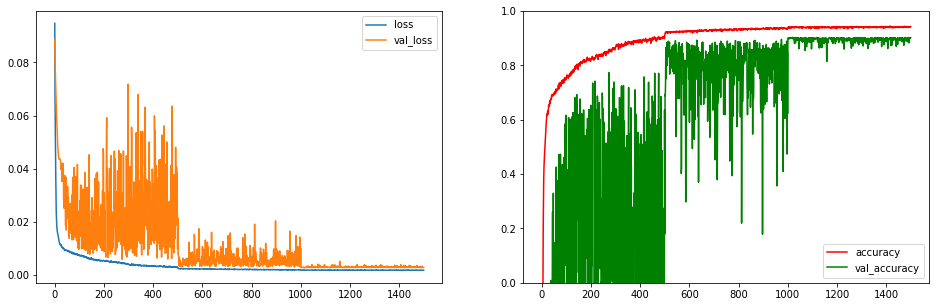

In [ ]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

ax1.plot(np.array(loss),label="loss")
ax1.plot(np.array(val_loss),label="val_loss")
ax1.legend();

ax2.plot(np.array(r2_score),label="accuracy", c="r")
ax2.plot(np.array(val_r2_score),label="val_accuracy", c="g")
ax2.set_ylim(0,1)
ax2.legend();

Les grands pics dans les graphes correspondent aux changement de learning rate a certains moment durant l'apprentissage. Ayant commencé avec `lr=1e-5`, on a finit avec `lr=1e-7` en passant par `lr=1e-6`.

## Quelques prédictions

Si le modèle à été entrainé à l'aide des générateurs de donnée de Keras, alors il faudra manuellement contruire le jeu de données test. C'est ce qui est montré ci-bas.

In [ ]:
## Load Y test from disk
# X_test = np.empty((len(partitions['test']-1350), 64, 64, 48))
# Y_test = np.empty((len(partitions['test']-1350), 64, 64))

# for i in partitions['test']:
#     X_test[i-1350] = np.load('inputs/' + str(i-1350) + '.npy')
#     Y_test[i-1350] = np.load('outputs/' + str(i-1350) + '.npy')[:,:,0]

In [ ]:
hat_Y_test = myVnet.model.predict(X_test)[:,:,:,0]
# hat_Y_test.shape, hat_Y_test.max()

In [ ]:
Y_test.shape, hat_Y_test.shape

((183, 64, 64), (183, 64, 64))

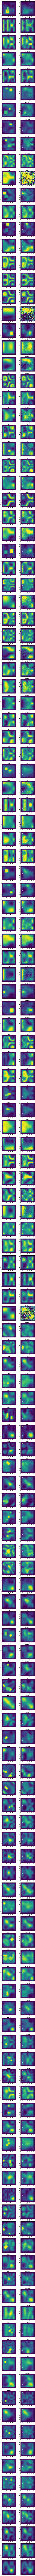

In [ ]:
lenTest = int(len(Y_test)/1.2)

fig,ax=plt.subplots(lenTest,2, figsize=(2*5,lenTest*5))

# vmin, vmax = 0, 1
vmin, vmax = None, None

for i in range(lenTest):
    # vmin, vmax = min([Y_test[i].min(), hat_Y_test[i].min()]), max([Y_test[i].max(), hat_Y_test[i].max()])   ## Une échelle particulière a chaque paire (true, predict) 
    vmin, vmax = min([Y_test[i].min()]), max([Y_test[i].max()])
    # if i==0:
    ax[i,0].set_title("Label "+str(i))  
    ax[i,1].set_title("Prédiction "+str(i))  
    ax[i,0].imshow(Y_test[i], origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(hat_Y_test[i], origin="lower", vmin=vmin, vmax=vmax)

On constate qu'après 1500 époques, le modèles est capable de prédire toutes sortes de densités, y compris celles contenant des tumeurs (zones de discontinuités rectagulaires, des rectangles inclinés, des disques, ou des gaussiennes observées sur certaines figures). A vu d'oeil, on dirait que:
- le modèle a beacoup plus de mal à détecter des **disques**, vu qu'il les ignore souvent (voir prédiction 141); Ce phénomène s'observe aussi au niveau des simulations du problème direct où on observe que les ondes contournent plus facilement les obstacles circulaires, ce qui rend difficile la détection de l'impact de l'obstcle sur les signaux aux bords.
- le réseau a moins de mal avec avec des **rectangles**, droits ou inclinés de 45$^o$
- a peine une difficulté avec des **gaussiennes**

On constate aussi que le modèle a du mal avec certaines densité **"trop" triviales**, bien qu'elles soient continuent (voir prédiction 18).   

Cependant, les meilleurs résultats sont obtenus pour des densités continues. Ce constat est confirmé par les 5 meilleures prédictions ci-bas.

[(66, 0.0005423297), (60, 0.0005428967), (48, 0.0005635413), (73, 0.0008268173), (14, 0.0008511937)]


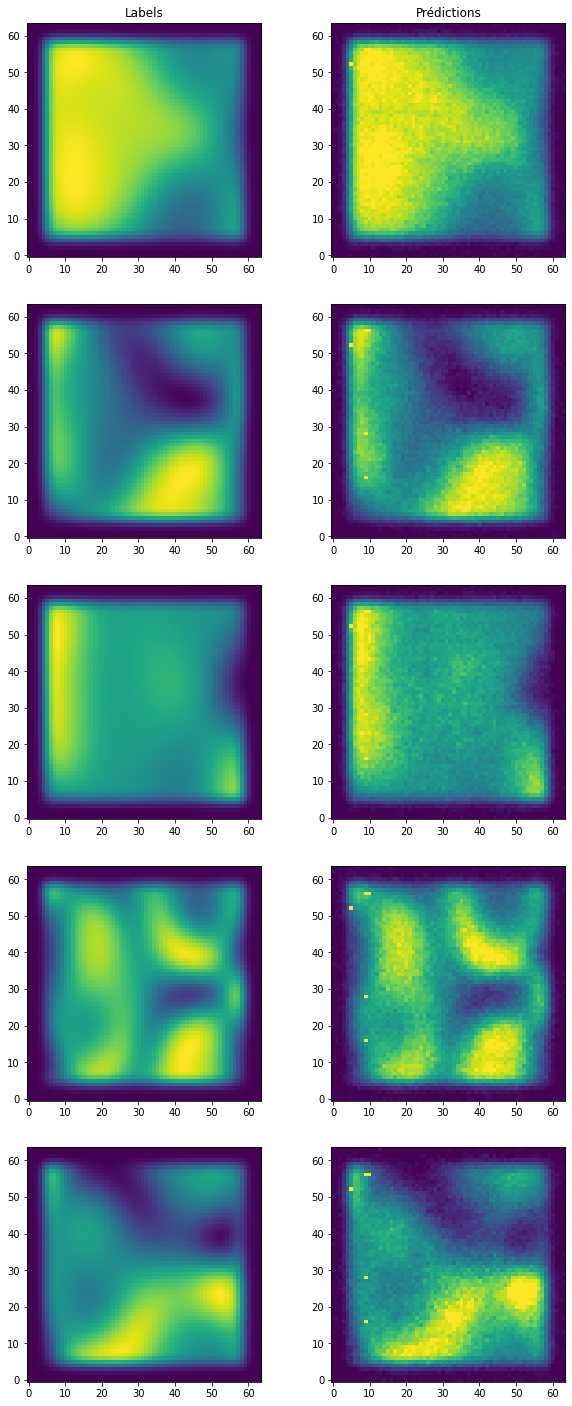

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
listErrors = []

for i in range(lenTest):
  listErrors.append((i, mse(Y_test[i], hat_Y_test[i]).numpy()))
  # print(listErrors)

listErrors.sort(key=lambda x:x[1])
print(listErrors[:5])

fig,ax=plt.subplots(5,2, figsize=(2*5,5*5))

for i in range(5):
    Y_true = Y_test[listErrors[i][0]]
    Y_pred = hat_Y_test[listErrors[i][0]]
    vmin, vmax = min([Y_true.min()]), max([Y_true.max()])
    
    if i==0:
      ax[i,0].set_title("Labels")  
      ax[i,1].set_title("Prédictions") 

    ax[i,0].imshow(Y_true, origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(Y_pred, origin="lower", vmin=vmin, vmax=vmax)

## Savegarde du model

In [ ]:
# myVnet.model.save("VNET09.h5")